# LRP-PF-AUC for VGG16

Try Region Perturbation using zennit on VGG16.

In [1]:
%load_ext autoreload
%autoreload 2

## LRP

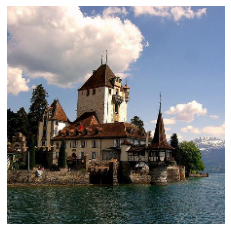

In [2]:
from typing import Callable, Dict, List, Tuple, Union

import numpy
import torch
import torchvision
from matplotlib import pyplot as plt
from zennit.composites import NameMapComposite
from zennit.core import BasicHook, stabilize
from zennit.image import imgify
# from lrp.rules import LrpEpsilonRule, LrpGammaRule, LrpZBoxRule, LrpZeroRule
from zennit.rules import Epsilon, Gamma, ZBox
from zennit.torchvision import VGGCanonizer

import lrp.plot
from lrp import image, rules
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear


# the LRP-Epsilon from the tutorial
class GMontavonEpsilon(BasicHook):
    def __init__(self, stabilize_epsilon=1e-6, epsilon=0.25):
        super().__init__(
            input_modifiers=[lambda input: input],
            param_modifiers=[lambda param, _: param],
            output_modifiers=[lambda output: output],
            gradient_mapper=(lambda out_grad, outputs: out_grad / stabilize(
                outputs[0] + epsilon * (outputs[0] ** 2).mean() ** .5, stabilize_epsilon)),
            reducer=(lambda inputs, gradients: inputs[0] * gradients[0])
        )

# Input data
# Image is in RGB mode with range [0,1]
img_bgr_hwc_float_0_1: numpy.array = image.load_img_norm_zero_one(
    '../../../data/castle2.jpg')
X = lrp.norm.ImageNetNorm.transform(img_bgr_hwc_float_0_1)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)
X.requires_grad = True

plt.axis('off')
lrp.plot.plot_imagenet(X)

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type: LayerFilter = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

name_map: List[Tuple[List[str], rules.LrpRule,
                     Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), ZBox(low=low, high=high)),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), Gamma(0.25)),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), GMontavonEpsilon(stabilize_epsilon=0, epsilon=0.25)),
    (filter_by_layer_index_type(lambda n: 31 <= n), Epsilon(0)),
]

# create the composite from the name map
composite = NameMapComposite(name_map, canonizers=[VGGCanonizer()])

R = None
# with composite.context(model) as modified_model:
#   # R: torch.Tensor = lrp_instance.relevance(X)
#   output = modified_model(X)
#   output[0].max().backward()

#   R = X.grad


composite.register(model)
# R: torch.Tensor = lrp_instance.relevance(X)
output = model(X)
output[0].max().backward()

R = X.grad

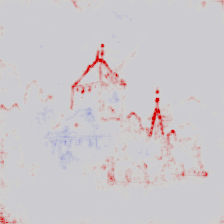

In [3]:
imgify(
    R.detach().cpu().sum(1),
    level=4.5,
    symmetric=True,
    grid=True,
    cmap='seismic')

## Region Perturbation

Try Region Perturbation with inpainting enabled.

Finished '_flip' in 0.0708 secs
Finished '_flip' in 0.0695 secs
Finished '_flip' in 0.0685 secs
Finished '_flip' in 0.0655 secs
Finished '_flip' in 0.0684 secs
Finished '_flip' in 0.0671 secs
Finished '_flip' in 0.0699 secs
Finished '_flip' in 0.0771 secs
Finished '_flip' in 0.0750 secs
Finished '_flip' in 0.0755 secs
Finished '_flip' in 0.0737 secs
Finished '_flip' in 0.0756 secs
Finished '_flip' in 0.0754 secs
Finished '_flip' in 0.0782 secs
Finished '_flip' in 0.0763 secs
Finished '_flip' in 0.0770 secs
Finished '_flip' in 0.0768 secs
Finished '_flip' in 0.0778 secs
Finished '_flip' in 0.0782 secs
Finished '_flip' in 0.0786 secs
Finished '_flip' in 0.0769 secs
Finished '_flip' in 0.0800 secs
Finished '_flip' in 0.0789 secs
Finished '_flip' in 0.0799 secs
Finished '_flip' in 0.0828 secs
Finished '_flip' in 0.0796 secs
Finished '_flip' in 0.0794 secs
Finished '_flip' in 0.0695 secs
Finished '_flip' in 0.0629 secs
Finished '__call__' in 2.2361 secs


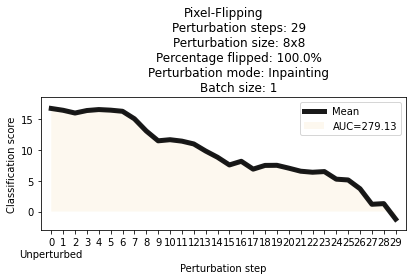

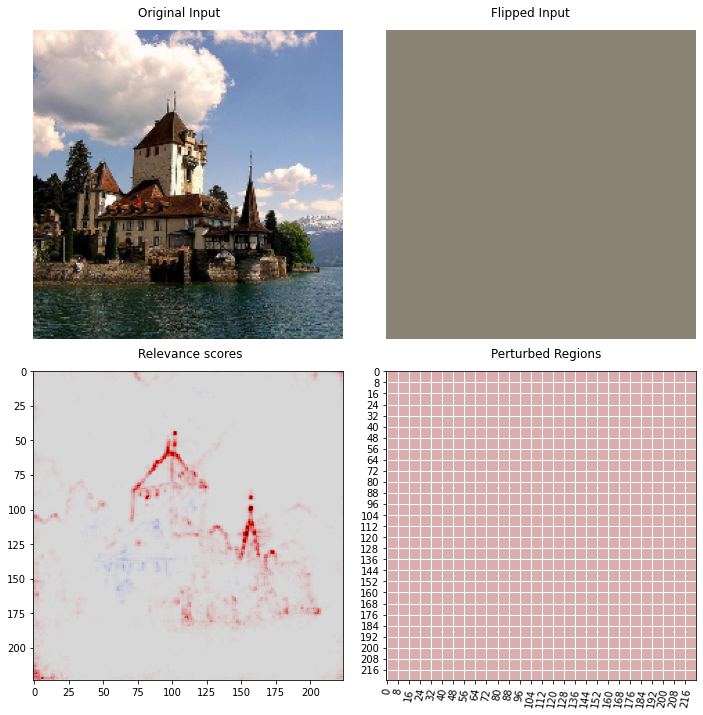

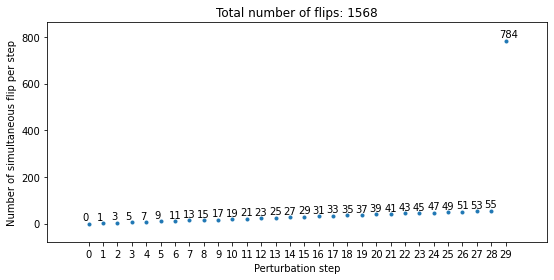

In [4]:
# %%script false --no-raise-error

from pf.core import PixelFlipping
# Parameters for cell: input_nchw, relevance_scores_nchw, lrp_instance
from pf.perturbation_modes.constants import PerturbModes

perturbation_steps: int = 29
perturbation_size: int = 8

pixel_flipping_instance: PixelFlipping = PixelFlipping(perturbation_steps=perturbation_steps,
                                                       perturbation_size=perturbation_size,
                                                       perturb_mode=PerturbModes.INPAINTING)
input_nchw: torch.Tensor = X.clone().detach()

# Enable reproducibility
torch.manual_seed(42)

relevance_scores_nchw: torch.Tensor = R.clone().detach()

# Function should return the (single-class) classification score for
# the given input to measure the difference between flips.
forward_pass: Callable[[torch.Tensor], float]
def forward_pass(input_nchw): return model(input_nchw)[:, 483]


# Run Pixel-Flipping algorithm
pixel_flipping_instance(input_nchw, relevance_scores_nchw, forward_pass)
pixel_flipping_instance.plot_class_prediction_scores()
pixel_flipping_instance.plot_image_comparison()
pixel_flipping_instance.plot_number_of_flips_per_step()

Finished '_flip' in 0.0663 secs
Finished '_flip' in 0.0655 secs
Finished '_flip' in 0.0658 secs
Finished '_flip' in 0.0639 secs
Finished '_flip' in 0.0734 secs
Finished '_flip' in 0.0684 secs
Finished '_flip' in 0.0653 secs
Finished '_flip' in 0.0646 secs
Finished '_flip' in 0.0655 secs
Finished '_flip' in 0.0649 secs
Finished '_flip' in 0.0639 secs
Finished '_flip' in 0.0673 secs
Finished '_flip' in 0.0672 secs
Finished '_flip' in 0.0665 secs
Finished '_flip' in 0.0663 secs
Finished '_flip' in 0.0658 secs
Finished '_flip' in 0.0684 secs
Finished '_flip' in 0.0739 secs
Finished '_flip' in 0.0702 secs
Finished '_flip' in 0.0703 secs
Finished '_flip' in 0.0688 secs
Finished '_flip' in 0.0661 secs
Finished '_flip' in 0.0665 secs
Finished '_flip' in 0.0690 secs
Finished '_flip' in 0.0676 secs
Finished '_flip' in 0.0691 secs
Finished '_flip' in 0.0676 secs
Finished '_flip' in 0.0703 secs
Finished '_flip' in 0.0668 secs
Finished '__call__' in 2.0231 secs


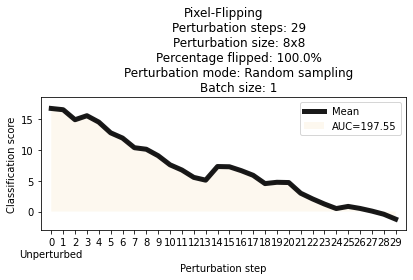

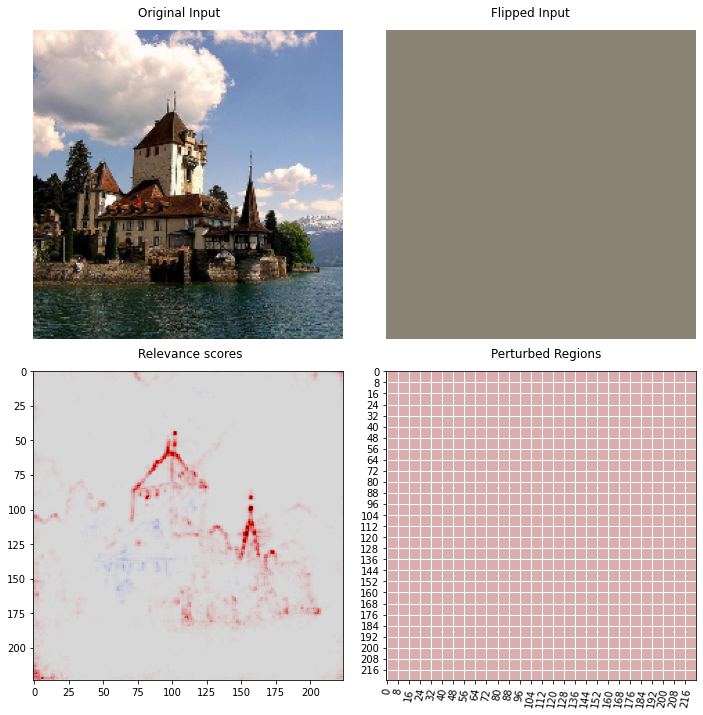

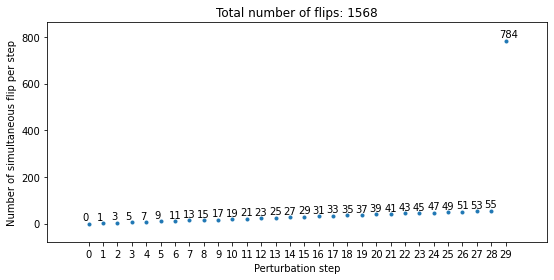

In [5]:
# %%script false --no-raise-error

from pf.core import PixelFlipping
# Parameters for cell: input_nchw, relevance_scores_nchw, lrp_instance
from pf.perturbation_modes.constants import PerturbModes

perturbation_steps: int = 29
perturbation_size: int = 8

pixel_flipping_instance: PixelFlipping = PixelFlipping(perturbation_steps=perturbation_steps,
                                                       perturbation_size=perturbation_size,
                                                       perturb_mode=PerturbModes.RANDOM)
input_nchw: torch.Tensor = X.clone().detach()

# Enable reproducibility
torch.manual_seed(42)

relevance_scores_nchw: torch.Tensor = R.clone().detach()

# Function should return the (single-class) classification score for
# the given input to measure the difference between flips.
forward_pass: Callable[[torch.Tensor], float]
def forward_pass(input_nchw): return model(input_nchw)[:, 483]


# Run Pixel-Flipping algorithm
pixel_flipping_instance(input_nchw, relevance_scores_nchw, forward_pass)
pixel_flipping_instance.plot_class_prediction_scores()
pixel_flipping_instance.plot_image_comparison()
pixel_flipping_instance.plot_number_of_flips_per_step()